In [36]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pydot
import seaborn as sns
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix,roc_curve,auc , classification_report
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

from PIL import Image
from PIL import Image as pil_image
from time import time
from PIL import ImageDraw
from glob import glob
from tqdm import tqdm
from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model , model_to_dot
from keras import backend as K
from keras import layers
from keras.preprocessing.image import save_img
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D,SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
from IPython.display import SVG

Using TensorFlow backend.


In [0]:
#data generation
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
valid_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
test_datagen = ImageDataGenerator()

In [8]:
training_set = train_datagen.flow_from_directory('/content/gdrive/My Drive/Colab Notebooks/Intel_Image/seg_train',target_size=(150,150),batch_size=8,class_mode = 'categorical')
valid_set = valid_datagen.flow_from_directory('/content/gdrive/My Drive/Colab Notebooks/Intel_Image/seg_test',target_size=(150,150),batch_size=8,class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('/content/gdrive/My Drive/Colab Notebooks/Intel_Image/seg_pred',target_size=(150,150),batch_size=8,class_mode = None )

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.


In [9]:
batch_size=8
training_set.target_size,valid_set.target_size,test_set.target_size

((150, 150), (150, 150), (150, 150))

In [0]:
train_size = training_set.n
valid_size = valid_set.n
test_size =test_set.n

In [11]:
test_size

7301

In [12]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

W0807 00:46:41.740427 139760209164160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 00:46:41.784770 139760209164160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 00:46:41.793802 139760209164160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 00:46:41.829224 139760209164160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0807 00:46:41.830097 1397602091

87916544/87910968 [==============================] - 2s 0us/step


In [13]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(6, activation='softmax')(x)

W0807 00:47:00.503536 139760209164160 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
#custom metrics 
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [16]:
# Compile the model
model.compile(optimizer=SGD(lr=1e-4,momentum=0.99), loss='categorical_crossentropy', metrics=['accuracy',categorical_accuracy, top_2_accuracy, top_3_accuracy])

W0807 00:47:07.040001 139760209164160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [18]:
#train the model
history = model.fit_generator(training_set,steps_per_epoch = train_size/batch_size,epochs = 1 # For the testing,Only using 1 epoch (otherwise will take weeks to train)
                              ,validation_data = valid_set,validation_steps  = valid_size/batch_size)
#evaluating the model
eval = model.evaluate_generator(generator=valid_set,steps=valid_size/batch_size)
print('accuracy=',eval[1])

W0807 00:47:16.011281 139760209164160 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
1755/1754 [==============================] - 5122s 3s/step - loss: 0.6878 - acc: 0.7495 - categorical_accuracy: 0.7495 - top_2_accuracy: 0.9038 - top_3_accuracy: 0.9568 - val_loss: 0.3939 - val_acc: 0.8527 - val_categorical_accuracy: 0.8527 - val_top_2_accuracy: 0.9673 - val_top_3_accuracy: 0.9883
accuracy= 0.864


In [0]:
y_pred=model.predict_generator(generator=test_set,steps=valid_size//batch_size)
y_pred=np.argmax(y_pred,axis=1)

In [20]:
print('confusion matrix')
print(confusion_matrix(valid_set.classes,y_pred))
#confusion_matrix
cm=confusion_matrix(valid_set.classes,y_pred)
cm_df=pd.DataFrame(cm,index=['buildings','foresst','glacier','mountain','sea','street'],columns=['buildings','foresst','glacier','mountain','sea','street'])

confusion matrix
[[  0   0 298  27 100  12]
 [  0   0 327  27 110  10]
 [  0   0 375  32 131  15]
 [  1   0 352  35 125  12]
 [  0   0 340  35 128   7]
 [  0   0 343  32 111  15]]


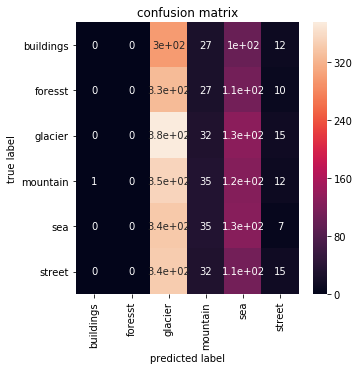

In [21]:
plt.figure(figsize=(5,5))
sns.heatmap(cm_df,annot=True)
plt.title('confusion matrix')
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.savefig('confusion')
plt.show()

In [22]:
#classification_report
print('classification report')
target_names=['buildings','foresst','glacier','mountain','sea','street']
print(classification_report(valid_set.classes,y_pred,target_names=target_names))

classification report
              precision    recall  f1-score   support

   buildings       0.00      0.00      0.00       437
     foresst       0.00      0.00      0.00       474
     glacier       0.18      0.68      0.29       553
    mountain       0.19      0.07      0.10       525
         sea       0.18      0.25      0.21       510
      street       0.21      0.03      0.05       501

    accuracy                           0.18      3000
   macro avg       0.13      0.17      0.11      3000
weighted avg       0.13      0.18      0.12      3000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
#test set prediction
test_set.reset()
pred=model.predict_generator(test_set,steps=test_size/batch_size,verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

labels = (training_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]


913/912 [==============================] - 1126s 1s/step


In [0]:
#saving the predictions to csv
filenames=test_set.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("/content/gdrive/My Drive/Colab Notebooks/Intel_Image/InceptionV3results.csv",index=False)

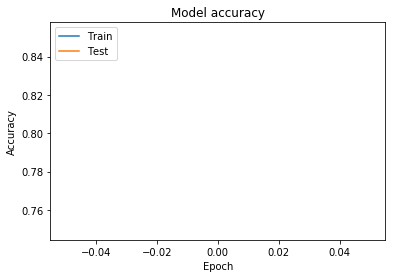

In [28]:
#plotting accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('modelacc')
plt.show()

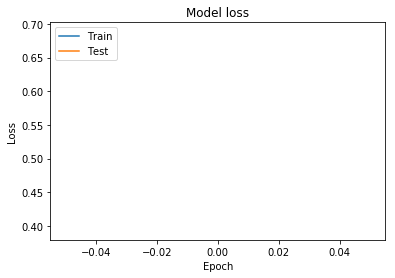

In [29]:
#plotting loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('modelloss')
plt.show()
